In [1]:
!pip install opencv-python

  Using cached opencv_python-4.7.0.68-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)


In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas

  Using cached matplotlib-3.6.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached contourpy-1.0.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (296 kB)


In [10]:
# Open images and labels
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

In [11]:
# Open images and labels
# import cv2
import numpy as np
import json
import math
import os

# Do this in a function
def get_labels_and_image(camera_name, img_name):
    # Open image file
    # join path
    # img = cv2.imread(os.path.join('dataset', "images",  camera_name, '{}.JPG'.format(img_name)))
    # Open json label file
    labels = open(os.path.join('dataset', 'CompleteAnnotations_2016-07-11', '{}.json'.format(camera_name)), 'r')
    # Parse json file
    labels = json.load(labels)
    recs = []
    for i in labels["dots"]:
        if i["imName"] == img_name:
            recs.append(i)
    return recs

# Create a function to save the labels
def save_labels(squares, camera_name, img_name):
    # Create a file
    # Check if the directory exists if not, create it recursively
    if not os.path.exists(os.path.join('dataset', 'labels', camera_name)):
        os.makedirs(os.path.join('dataset', 'labels', camera_name))
        
    f = open(os.path.join('dataset', 'labels', camera_name, '{}.txt'.format(img_name)), 'w')
    # Write the labels
    for i in range(len(squares)):
        # Square center
        x, y = (squares[i][0]), (squares[i][1])
        # Square width and height
        w, h = squares[i][2], squares[i][3]
        f.write('0 {} {} {} {}\n'.format(x, y, w, h))

# Create a function to process the labels
def process_labels(camera_name, img_name):
    # Get the image and the labels
    recs = get_labels_and_image(camera_name, img_name)

    if recs[0]["xy"] == [] or recs[0]["xy"] == None or recs[0]["xy"] == "_NaN_":
        return

    # Squares
    squares = []
    visited = False
    for i in recs[0]["xy"]:
        # If i is not a list, or enpty, skip it
        if type(i) != list or i == [] or i == None or i == "_NaN_" or i == [''] or i == '':
            continue

        if not visited:
            for j in i:
                if type(j) != list or j == [] or j == None or j == "_NaN_" or j == [''] or j == '':
                    continue
        
                # plt.scatter(j[0], j[1], color='r', s=10)
                # Each square for a given point is proportional to what is the y value of that point. Initating from 0 to the height of the image
                # There is a linear relationship between the y value of the point and the area of the square
                # The area of the square is proportional to the y value of the point
                # To calculate the area of the square, we need to know the height of the image
                # Get the height of the image
                height = 1536
                width = 2048
                # Get the y value of the point
                y = j[1]
                # Calculate the area of the square
                area = ((y/height) + 0.1) * 120000 - 12000
                
                # Save the square
                if area > 0:
                    # Turn the area into a percentage of the image                    
                    x = j[0] / width * 100
                    y = j[1] / height * 100
                    w = math.sqrt(area) / width * 100
                    h = math.sqrt(area) / height * 100
                    squares.append((x, y, w, h))
                    visited = True

    # Save the labels
    save_labels(squares, camera_name, img_name)
    return squares

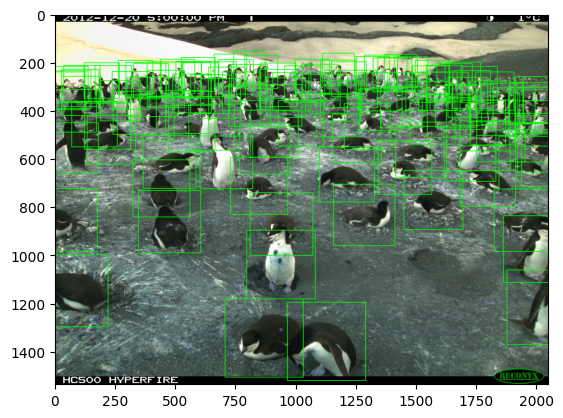

In [12]:

# Camera
camera_name = 'BAILa'
# Image name
img_name = 'BAILa2014a_000003'
# Open Image
img = cv2.imread(os.path.join('dataset/images', camera_name, '{}.JPG'.format(img_name)))

process_labels(camera_name, img_name)
# Open labels
labels = open(os.path.join('dataset/labels', camera_name, "{}.txt".format(img_name)),'r')

# Parse labels
labels = labels.read().split('\n')
labels = [i.split(' ') for i in labels]

# Get the float labels
for i in range(len(labels)):
    if labels[i]!= '':
        for j in range(len(labels[i])):
            if labels[i][j] != '':
                labels[i][j] = float(labels[i][j])
# print(labels)

# Transform from percentage to pixels
# Get the height and width of the image
height, width, _ = img.shape
# Transform the labels
squares = []
for i in labels:
    if i != [] and i != ['']:
        squares.append([i[1] / 100 * width, i[2] / 100 * height, i[3] / 100 * width , i[4]/ 100 * height])

# Draw the squares
for i in squares:
    x1 = int(i[0] + i[2]/2)
    y1 = int(i[1] + i[3]/2)
    x2 = int(i[0] - i[2]/2)
    y2 = int(i[1] - i[3]/2)

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# # Show the image
plt.imshow(img)
plt.show()

# print(img.shape)



In [15]:
# make a list of all the images in the dataset
# for each label file, get the image name
# print(os.listdir('dataset/labels/BAILa'))
files = []
for i in os.listdir('dataset/labels/'):
    print(i)
    img_name = i.split('.')[-2]
    files.append(img_name)

import random

# Sample 80% of the images for training
train_files = random.sample(files, int(len(files) * 0.8))
# Get the test files
val = [i for i in files if i not in train_files]

# Create a function to create the train.txt and val.txt files
def create_train_val_files(train_files, val_files):
    # Create the train.txt file
    f = open('train.txt', 'w')
    for i in train_files:
        # Check if the path exists
        if not os.path.exists(os.path.join('./images')):
            os.makedirs(os.path.join('./images'))
        f.write('./images/{}.JPG\n'.format(i))

    for i in val_files:
        # Check if the path exists
        if not os.path.exists(os.path.join('./images')):
            os.makedirs(os.path.join('./images'))
        f.write('./images/{}.JPG\n'.format(i))

    # Create the train.txt and val.txt files
    f = open('train.txt', 'w')
    for i in train_files:
        f.write('./images/{}.JPG\n'.format(i))
    f.close()

    f = open('val.txt', 'w')
    for i in val_files:
        f.write('./images/{}.JPG\n'.format(i))
    f.close()




create_train_val_files(train_files, val)

BAILa2014a_000001.txt
BAILa2014a_000003.txt
BAILa2014a_000004.txt
BAILa2014a_000005.txt
BAILa2014a_000006.txt
BAILa2014a_000011.txt
BAILa2014a_000013.txt
BAILa2014a_000015.txt
BAILa2014a_000016.txt
BAILa2014a_000018.txt
BAILa2014a_000019.txt
BAILa2014a_000020.txt
BAILa2014a_000028.txt
BAILa2014a_000032.txt
BAILa2014a_000035.txt
BAILa2014a_000038.txt
BAILa2014a_000039.txt
BAILa2014a_000041.txt
BAILa2014a_000045.txt
BAILa2014a_000046.txt
BAILa2014a_000048.txt
BAILa2014a_000049.txt
BAILa2014a_000051.txt
BAILa2014a_000052.txt
BAILa2014a_000055.txt
BAILa2014a_000058.txt
BAILa2014a_000060.txt
BAILa2014a_000065.txt
BAILa2014a_000071.txt
BAILa2014a_000080.txt
BAILa2014a_000084.txt
BAILa2014a_000085.txt
BAILa2014a_000088.txt
BAILa2014a_000091.txt
BAILa2014a_000094.txt
BAILa2014a_000095.txt
BAILa2014a_000097.txt
BAILa2014a_000098.txt
BAILa2014a_000099.txt
BAILa2014a_000101.txt
BAILa2014a_000102.txt
BAILa2014a_000104.txt
BAILa2014a_000105.txt
BAILa2014a_000106.txt
BAILa2014a_000108.txt
BAILa2014a